Створимо набір даних з нашого csv файлу

In [111]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

def getDataset():
    data = pd.read_csv('Export1.csv',sep=';',encoding='cp1252')
    return data

dataset = getDataset()

Перевіримо їх на нормальність

In [112]:
dataset = dataset.drop(dataset.columns[[0, 1, 2, 3, 4, 6]], axis=1)

import scipy.stats as stats
def kolm_smirn_check(dFrame, column):
    ks_statistic, p_value = stats.kstest(dFrame[column], 'norm')
    if p_value > 0.05: return True
    return False

def pearson_check(dFrame, column):
    statistic, p_value = stats.normaltest(dFrame[column])
    if p_value > 0.05: return True
    return False

print("#1 test - Kolmagorov-Smirnov test,\n#2 test - Pearson test\n")
for c in dataset.columns:
    print('{0:<15}'.format(c + ":"),f"#1 test - {kolm_smirn_check(dataset, c)}, #2 test - {pearson_check(dataset, c)};")


#1 test - Kolmagorov-Smirnov test,
#2 test - Pearson test

ratio:          #1 test - False, #2 test - False;
gdp:            #1 test - False, #2 test - False;
population:     #1 test - False, #2 test - False;
sales_of_cigarettes_per_adult_per_day: #1 test - False, #2 test - False;
annual_co2_emissions_tonnes: #1 test - False, #2 test - False;


Перевіримо коефіцієнти корреляції

In [113]:
dataset.corr()

,ratio,gdp,population,sales_of_cigarettes_per_adult_per_day,annual_co2_emissions_tonnes
ratio,1.000000,0.774552,0.137843,-0.047489,0.090640
gdp,0.774552,1.000000,0.243990,-0.167556,0.247694
population,0.137843,0.243990,1.000000,0.045570,0.955826
sales_of_cigarettes_per_adult_per_day,-0.047489,-0.167556,0.045570,1.000000,0.003515
annual_co2_emissions_tonnes,0.090640,0.247694,0.955826,0.003515,1.000000


Розіб'ємо дані на тренувальні та тестові параметри та залежну змінну

In [114]:
from sklearn.model_selection import train_test_split

data = dataset.iloc[:,1:5]
fact = dataset['ratio']
X_train, X_test, Y_train, Y_test = train_test_split(data, fact,test_size = 0.25,random_state = 0)

Лінійна регресія.
Підготуємо всі можливі набори параметрів для моделювання та власне застосуємо лінійну регресію до кожного з них

In [115]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

X_variant_tuples = ["gdp", "population", "sales_of_cigarettes_per_adult_per_day", "annual_co2_emissions_tonnes",
    
                    ["gdp", "population", "sales_of_cigarettes_per_adult_per_day", "annual_co2_emissions_tonnes"],
                    ["gdp", "population"], ["gdp", "sales_of_cigarettes_per_adult_per_day"], ["gdp", "annual_co2_emissions_tonnes"],
                    ["population", "sales_of_cigarettes_per_adult_per_day"], ["population", "annual_co2_emissions_tonnes"],
                    ["sales_of_cigarettes_per_adult_per_day", "annual_co2_emissions_tonnes"],

                    ["gdp", "population", "sales_of_cigarettes_per_adult_per_day"], 
                    ["gdp", "population","annual_co2_emissions_tonnes"], 
                    ["gdp", "sales_of_cigarettes_per_adult_per_day", "annual_co2_emissions_tonnes"], 
                    ["population", "sales_of_cigarettes_per_adult_per_day", "annual_co2_emissions_tonnes"]]

linear_regression_models_list = []

for i in range(len(X_variant_tuples)):
    if i < 4: 
        linear_regression_models_list.append(LinearRegression().fit(X_train[X_variant_tuples[i]].to_numpy().reshape(-1,1), Y_train))
    else:
        linear_regression_models_list.append(LinearRegression().fit(X_train[X_variant_tuples[i]], Y_train))
        

Тепер для кожної нашої моделі спроєктуємо передбачення та будемо зберігати його в массиві даних

In [116]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
MSE = []
R2 = []

prediction = []

def predict_by(prediction, s):
    for i in range(len(X_variant_tuples)):
        if i < 4:
            prediction.append(s[i].predict(X_test[X_variant_tuples[i]].to_numpy().reshape(-1,1)))
        else:
            prediction.append(s[i].predict(X_test[X_variant_tuples[i]]))

    return prediction

prediction = predict_by(prediction, linear_regression_models_list)
#print(prediction)

Для кожного з передбачень обрахуємо MSE та R2.
Для MSE побудужмо графік для наочності та аби зрозуміти, яка сама модель є ефективнішою

MSE plot


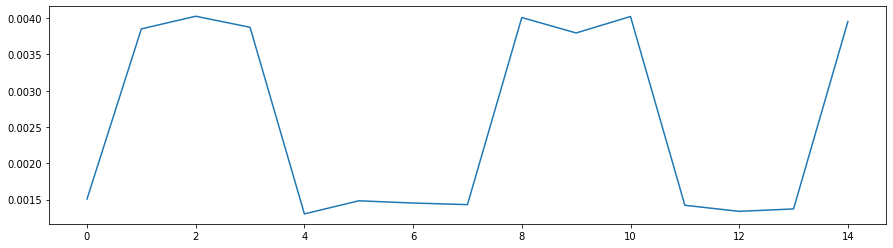

In [117]:
for i in range(len(prediction)):
    MSE.append(mean_squared_error(Y_test,prediction[i]))
    R2.append(r2_score(Y_test,prediction[i]))

import matplotlib.pyplot as plt
#print(MSE)
print("MSE plot")
plt.plot(MSE)
plt.show()

#print("R2 Plot")
#plt.plot(R2)
#plt.show()
#print(linear_regression_models_list[4].score(X_train, Y_train))

Програмно порахуємо та визначимо, яка модель є найкращою

In [118]:
def get_minvalue(inputlist):
    #get the minimum value in the list
    min_value = min(inputlist)
    #return the index of minimum value 
    min_index=inputlist.index(min_value)
    return min_index

print("Best model is:")
print(f"linear model by {X_variant_tuples[get_minvalue(MSE)]} params")
print("Just score: ", linear_regression_models_list[get_minvalue(MSE)].score(X_train, Y_train))
print("Particulary R2_score: ", r2_score(Y_test,prediction[get_minvalue(MSE)]))

Best model is:
linear model by ['gdp', 'population', 'sales_of_cigarettes_per_adult_per_day', 'annual_co2_emissions_tonnes'] params
Just score:  0.6289405784063854
Particulary R2_score:  0.6572330194601623


In [119]:
from sklearn.linear_model import LogisticRegression

Тепер, знаючи, яка модель є найкращою, за допомогою кастомної функції, продемонструємо графік Learning Curve

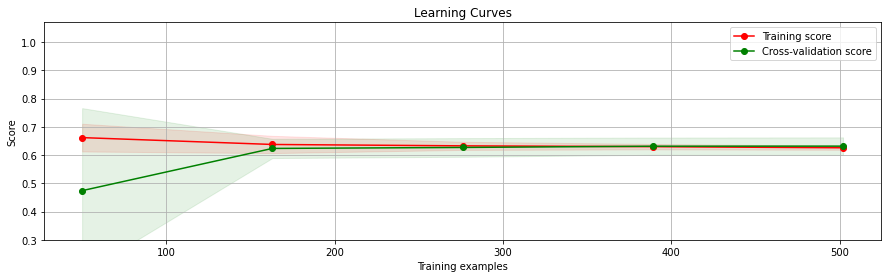

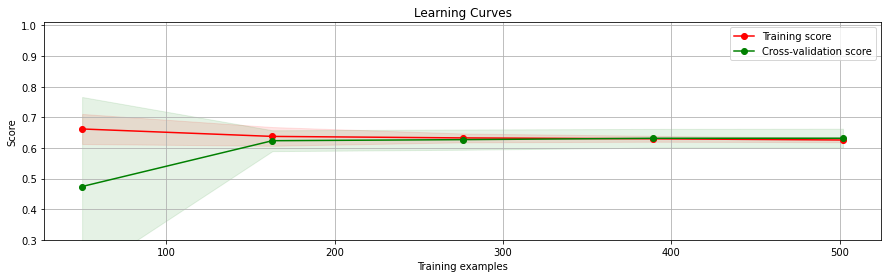

In [120]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(linear_regression_models_list[4], "Learning Curves", X_train, Y_train, (0.3, 1.01), cv=cv, n_jobs=4)
plt.show()
plot_learning_curve(linear_regression_models_list[12], "Learning Curves", X_train, Y_train, (0.3, 1.01), cv=cv, n_jobs=4)
plt.show()

Графік точності передбачення

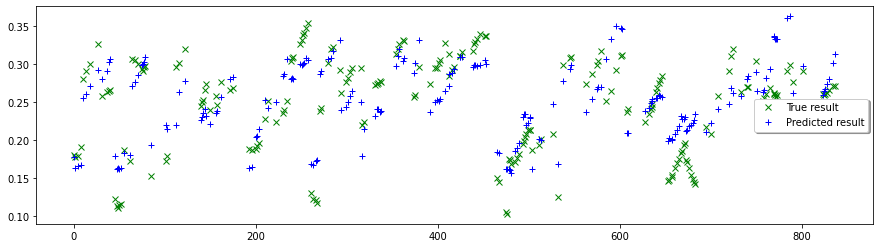

In [121]:
def show_accuracy_plot(estimator):
    plt.rcParams["figure.figsize"] = (15,4)
    plt.gca().axes.get_yaxis().set_visible(True)
    plt.plot(X_test.index, Y_test, "gx", label = "True result")
    plt.plot(X_test.index, estimator.predict(X_test), "b+", label = "Predicted result")
    plt.legend(loc="center right", shadow=True)
    plt.show()
    
show_accuracy_plot(linear_regression_models_list[4])

Random Forest Regression.
Для кожного кортежу застосуємо дану модель

In [122]:
from sklearn.ensemble import RandomForestRegressor

random_forest_regression_model_list = []

for i in range(len(X_variant_tuples)):
    if i < 4: 
        random_forest_regression_model_list.append(RandomForestRegressor(n_estimators=300, max_features=5).fit(X_train[X_variant_tuples[i]].to_numpy().reshape(-1,1), Y_train))
    else:
        random_forest_regression_model_list.append(RandomForestRegressor(n_estimators=300, max_features=5).fit(X_train[X_variant_tuples[i]], Y_train)) 

In [123]:
random_forest_prediction = []
random_forest_prediction = predict_by(random_forest_prediction, random_forest_regression_model_list)

[0.0012913720060507648, 0.003353449220386842, 0.004737047267191759, 0.00327431039412926, 0.0002630879615989888, 0.00041910504125740073, 0.0007793568363251537, 0.000510292733670671, 0.001605575667080666, 0.0009319604909999988, 0.0020515374520653266, 0.00029734183036465335, 0.00030763964711992775, 0.00039012250530022204, 0.0007007168585642124]


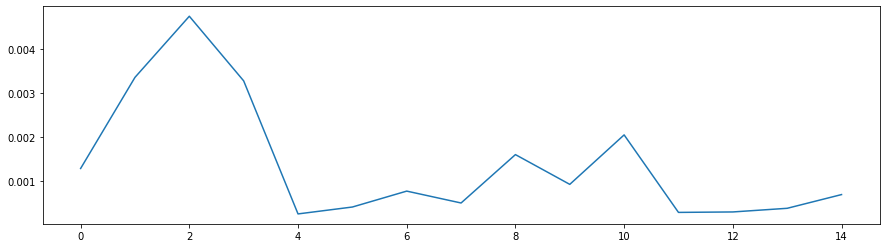

In [124]:
MSE_forest = []
R2_forest = []
for i in range(len(random_forest_prediction)):
    MSE_forest.append(mean_squared_error(Y_test,random_forest_prediction[i]))
    R2_forest.append(r2_score(Y_test,random_forest_prediction[i]))

print(MSE_forest)
plt.plot(MSE_forest)
plt.show()


In [125]:

print("Best model is:")
print(f"Random Forest Regressor model by {X_variant_tuples[get_minvalue(MSE_forest)]} params")
print("Just score: ", random_forest_regression_model_list[get_minvalue(MSE_forest)].score(X_train, Y_train))
print("Particulary R2_score: ", r2_score(Y_test,random_forest_prediction[get_minvalue(MSE_forest)]))

Best model is:
Random Forest Regressor model by ['gdp', 'population', 'sales_of_cigarettes_per_adult_per_day', 'annual_co2_emissions_tonnes'] params
Just score:  0.9923617888324052
Particulary R2_score:  0.9307710191583165


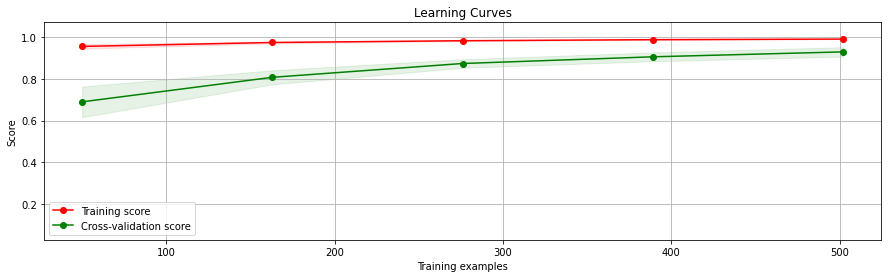

In [126]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(random_forest_regression_model_list[4], "Learning Curves", X_train, Y_train, (0.03, 1.07), cv=cv, n_jobs=4)
plt.show()

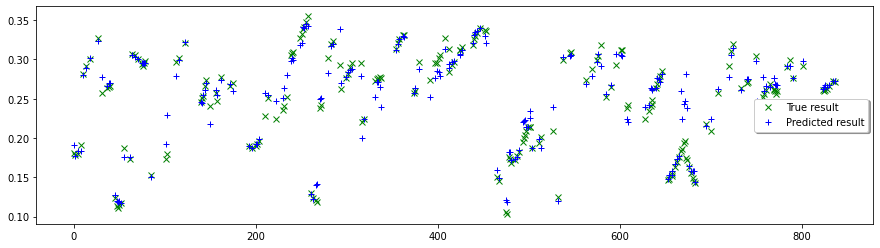

In [127]:
show_accuracy_plot(random_forest_regression_model_list[4])

The k-Nearest Neighbors (kNN) Algorithm

In [128]:
from sklearn.neighbors import KNeighborsRegressor

k_Nearest_regression_model_list = []

#model = RandomForestRegressor(n_estimators=500, max_features=5).fit(X,y)
for i in range(len(X_variant_tuples)):
    if i < 4: 
        k_Nearest_regression_model_list.append(KNeighborsRegressor(n_neighbors=150).fit(X_train[X_variant_tuples[i]].to_numpy().reshape(-1,1), Y_train))
    else:
        k_Nearest_regression_model_list.append(KNeighborsRegressor(n_neighbors=150).fit(X_train[X_variant_tuples[i]], Y_train))
        

In [129]:
k_Nearest_prediction = []
k_Nearest_prediction = predict_by(k_Nearest_prediction, k_Nearest_regression_model_list)
#print(k_Nearest_prediction)

[0.0010802690476732235, 0.003654532619633476, 0.0038980042817149323, 0.00328688337748756, 0.0032818870978392626, 0.003654532619633476, 0.0010802690476732235, 0.00328688337748756, 0.003654532619633476, 0.0032818870978392626, 0.00328688337748756, 0.003654532619633476, 0.0032818870978392626, 0.00328688337748756, 0.0032818870978392626]


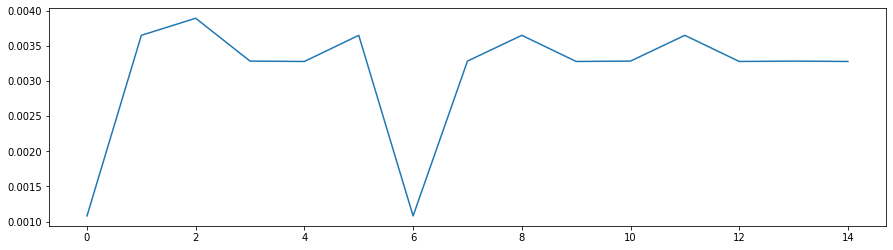

In [130]:
MSE_k_Nearest = []
R2_k_Nearest = []
for i in range(len(k_Nearest_prediction)):
    MSE_k_Nearest.append(mean_squared_error(Y_test,k_Nearest_prediction[i]))
    R2_k_Nearest.append(r2_score(Y_test,k_Nearest_prediction[i]))

print(MSE_k_Nearest)
#plt.plot(R2)
plt.plot(MSE_k_Nearest)
plt.show()



In [131]:
indexMinMSE_k_Nearest = np.sum((np.array(k_Nearest_prediction)- Y_test.to_numpy())**2,axis = 1).argmin()
MinMSE_k_Nearest = np.sum((np.array(k_Nearest_prediction) - Y_test.to_numpy())**2, axis = 1)
#print(MinMSE_k_Nearest)
print(indexMinMSE_k_Nearest)
print("Best model is:")
print(f"k Nearest model by {X_variant_tuples[indexMinMSE_k_Nearest]} params")

0
Best model is:
k Nearest model by gdp params


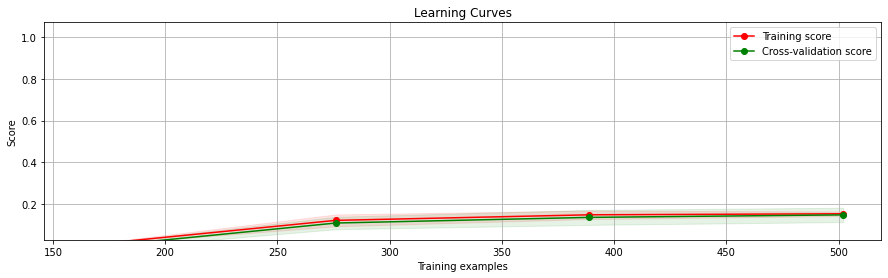

In [132]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(k_Nearest_regression_model_list[0], "Learning Curves", X_train, Y_train, (0.03, 1.07), cv=cv, n_jobs=4)
plt.show()

In [133]:
#show_accuracy_plot(k_Nearest_regression_model_list[0])

Gradient Boosting Regression

In [134]:
from sklearn.ensemble import GradientBoostingRegressor

GradientBoostingRegressor_regression_model_list = []

for i in range(len(X_variant_tuples)):
    if i < 4: 
       GradientBoostingRegressor_regression_model_list.append(GradientBoostingRegressor(random_state=0).fit(X_train[X_variant_tuples[i]].to_numpy().reshape(-1,1), Y_train))
    else:
        GradientBoostingRegressor_regression_model_list.append(GradientBoostingRegressor(random_state=0).fit(X_train[X_variant_tuples[i]], Y_train))

In [135]:
GradientBoostingRegressor_prediction = []
GradientBoostingRegressor_prediction = predict_by(GradientBoostingRegressor_prediction, GradientBoostingRegressor_regression_model_list)
#print(GradientBoostingRegressor_prediction)

In [136]:
MSE_GradientBoostingRegressor = []
R2_GradientBoostingRegressor = []
for i in range(len(GradientBoostingRegressor_prediction)):
    MSE_GradientBoostingRegressor.append(mean_squared_error(Y_test,GradientBoostingRegressor_prediction[i]))
    R2_GradientBoostingRegressor.append(r2_score(Y_test,GradientBoostingRegressor_prediction[i]))

print(MSE_GradientBoostingRegressor)
#plt.plot(R2)
plt.plot(MSE_GradientBoostingRegressor)
plt.show()

0.0003774600425782712
0.9575933994156017
0.900675143410847


In [137]:
indexMinMSE_GradientBoostingRegressor = np.sum((np.array(GradientBoostingRegressor_prediction)- Y_test.to_numpy())**2,axis = 1).argmin()
MinMSE_GradientBoostingRegressor = np.sum((np.array(GradientBoostingRegressor_prediction) - Y_test.to_numpy())**2, axis = 1)
#print(MinMSE_GradientBoostingRegressor)
print(indexMinMSE_GradientBoostingRegressor)
print("Best model is:")
print(f"k Nearest model by {X_variant_tuples[indexMinMSE_GradientBoostingRegressor]} params")

4
Best model is:
k Nearest model by ['gdp', 'population', 'sales_of_cigarettes_per_adult_per_day', 'annual_co2_emissions_tonnes'] params


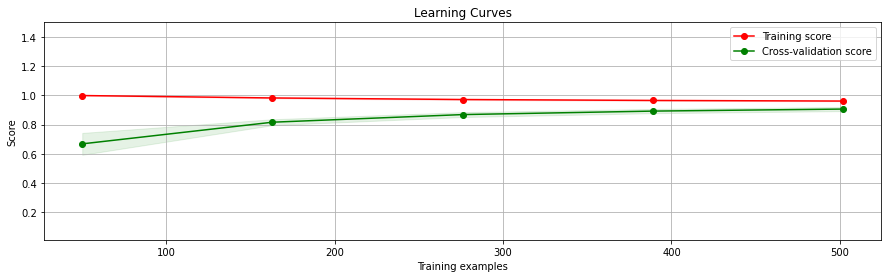

In [138]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(GradientBoostingRegressor_regression_model_list[4], "Learning Curves", X_train, Y_train, (0.01, 1.5), cv=cv, n_jobs=4)
plt.show()

In [139]:
show_accuracy_plot(GradientBoostingRegressor_regression_model_list[4])

NameError: name 'BayesianRidge_prediction' is not defined

In [ ]:
train_score = GradientBoostingRegressor_regression_model_list[4].score(X_train, Y_train)
#test_score = GradientBoostingRegressor_regression_model_list[4].score(X_test, Y_test)

print(mean_squared_error(Y_test, GradientBoostingRegressor_prediction[4]))
print(train_score);
print(r2_score(Y_test, GradientBoostingRegressor_prediction[4]))


0.0003774600425782712
0.9575933994156017
0.900675143410847
